In [74]:
import re, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from branca.colormap import LinearColormap
from IPython.display import HTML, display, IFrame
import base64

from ipyleaflet import Map, ImageOverlay, basemaps, WidgetControl
import ipywidgets as W
from ipywidgets import GridBox, Layout

### Configuración

In [75]:
BASE = Path("descargas_sentinelhub")  # carpeta de los TIF
LAKES = ["atitlan", "amatitlan"]      # subcarpetas
BANDS_SUFFIX = ".bands.tiff"    # 9 bandas: B02,B03,B04,B05,B07,B08,B8A,B11,B12 (float32)
MASK_SUFFIX  = ".mask.tiff"           # 2 bandas: SCL, dataMask (uint8)
SCL_BAD = {3,8,9,10,11}

# Umbrales del script CyanoLakes
MNDWI_thr = 0.42
NDWI_thr  = 0.4
FILTER_UABS = True

### Funciones de utilidad

In [76]:
def list_date_bases(lake_folder: Path):
    """
    Devuelve una lista de paths 'base' por fecha para un lago:
    BASE/lake/lake__YYYY-MM-DD  (sin sufijo)
    """
    bases = []
    for tif in lake_folder.glob(f"*__20??-??-??{BANDS_SUFFIX}"):
        date = re.search(r"__(\d{4}-\d{2}-\d{2})\.bands\.tiff$", tif.name).group(1)
        base = tif.with_suffix("").with_suffix("")
        bases.append((date, base))
    return sorted(bases, key=lambda x: x[0])

def load_stack(base_path: Path):
    """Lee el stack de 9 bandas (float32 reflectancia) y la máscara (SCL, dataMask)."""
    bands_path = base_path.with_suffix(BANDS_SUFFIX)
    mask_path  = base_path.with_suffix(MASK_SUFFIX)

    with rasterio.open(bands_path) as src:
        stack = src.read().astype("float32")
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 = stack

    with rasterio.open(mask_path) as msrc:
        m = msrc.read()
        scl, dm = m[0].astype("int16"), m[1].astype("int16")

    return (b02,b03,b04,b05,b07,b08,b8a,b11,b12), scl, dm

### Índices calculados del script de Cyanobacteria

In [77]:
def water_mask(b02,b03,b04,b08,b11,b12):
    ndvi  = (b08 - b04) / (b08 + b04 + 1e-6)                                     # (ndvi)
    mndwi = (b03 - b11) / (b03 + b11 + 1e-6)                                     # (mndwi)
    ndwi  = (b03 - b08) / (b03 + b08 + 1e-6)                                     # (ndwi)
    ndwi_leaves = (b08 - b11) / (b08 + b11 + 1e-6)                               # (ndwi_leaves)
    aweish  = b02 + 2.5*b03 - 1.5*(b08 + b11) - 0.25*b12                         # (aweish)
    aweinsh = 4*(b03 - b11) - (0.25*b08 + 2.75*b11)                              # (aweinsh)
    dbsi = ((b11 - b03) / (b11 + b03 + 1e-6)) - ndvi                             # (dbsi)

    ws = ((mndwi > MNDWI_thr) | (ndwi > NDWI_thr) | (aweinsh > 0.1879) |
          (aweish > 0.1112) | (ndvi < -0.2) | (ndwi_leaves > 1.0))

    if FILTER_UABS:
        ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))

    return ws

def fai(b04,b07,b8a):
    # FAI = B07 - (B04 + (B8A - B04) * (783-665)/(865-665))
    return b07 - (b04 + (b8a - b04) * ((783 - 665) / (865 - 665)))

def ndci(b04,b05):
    return (b05 - b04) / (b05 + b04 + 1e-6)

def chlorophyll_from_ndci(ndci_arr):
    # Polinomio del script
    return 826.57*ndci_arr**3 - 176.43*ndci_arr**2 + 19.0*ndci_arr + 4.071

def ndvi(b04,b08):
    return (b08 - b04) / (b08 + b04 + 1e-6)

def ndwi(b03,b08):
    return (b03 - b08) / (b03 + b08 + 1e-6)

### Procesamiento de `.tiffs` en base a su fecha

In [78]:
def process_one(base_path: Path):
    """Devuelve diccionario de métricas agregadas y mapas intermedios."""
    (b02,b03,b04,b05,b07,b08,b8a,b11,b12), scl, dm = load_stack(base_path)

    valid = (dm > 0) & (~np.isin(scl, list(SCL_BAD)))

    water = water_mask(b02,b03,b04,b08,b11,b12) & valid

    FAIv  = fai(b04,b07,b8a)
    NDCIv = ndci(b04,b05)
    chl   = chlorophyll_from_ndci(NDCIv)

    NDVIv = ndvi(b04,b08)
    NDWIv = ndwi(b03,b08)

    # agregados sobre agua
    def agg(masked):
        vals = masked[water]
        return dict(mean=float(np.nanmean(vals)) if vals.size else np.nan,
                    p90 =float(np.nanpercentile(vals,90)) if vals.size else np.nan,
                    p99 =float(np.nanpercentile(vals,99)) if vals.size else np.nan)

    metrics = {
        "chl_mean":  agg(chl)["mean"],
        "chl_p90":   agg(chl)["p90"],
        "FAI_mean":  agg(FAIv)["mean"],
        "NDCI_mean": agg(NDCIv)["mean"],
        "NDVI_mean": agg(NDVIv)["mean"],
        "NDWI_mean": agg(NDWIv)["mean"],
        "water_px":  int(water.sum())
    }
    maps = {"water": water, "chl": chl, "FAI": FAIv, "NDCI": NDCIv, "NDVI": NDVIv, "NDWI": NDWIv}
    return metrics, maps


### Recorrer ambos lagos y armar series (convirtiendo a arreglos de numpy)

In [79]:
rows = []
maps_cache = {}

for lake in LAKES:
    lake_folder = BASE / lake
    bases = list_date_bases(lake_folder)
    print(f"{lake}: {len(bases)} fechas encontradas")
    for date, base in bases:
        try:
            metrics, maps = process_one(base)
            rows.append({"lake": lake, "date": pd.to_datetime(date), **metrics})
            maps_cache.setdefault(lake, {})[date] = maps
        except Exception as e:
            print(f"[warn] {lake} {date}: {e}")

df = pd.DataFrame(rows).sort_values(["lake","date"]).reset_index(drop=True)
df.head()


atitlan: 29 fechas encontradas
amatitlan: 29 fechas encontradas


,lake,date,chl_mean,chl_p90,FAI_mean,NDCI_mean,NDVI_mean,NDWI_mean,water_px
0,amatitlan,2025-02-07,23.214016,45.584991,0.001404,0.310398,-0.28148,0.574654,133219
1,amatitlan,2025-02-10,NaN,NaN,NaN,NaN,NaN,NaN,0
2,amatitlan,2025-02-25,NaN,NaN,NaN,NaN,NaN,NaN,0
3,amatitlan,2025-02-27,31.240353,60.351524,0.020709,0.351973,0.07352,0.245286,109021
4,amatitlan,2025-03-02,NaN,NaN,NaN,NaN,NaN,NaN,0


### Llenado de los datos faltantes imputándolos con mediana

In [80]:
df["date"] = pd.to_datetime(df["date"])

START = "2025-02-01"
END   = "2025-08-01"
TARGET_CAL = pd.date_range(START, END, freq="D")

METRICS = ["chl_mean","FAI_mean","NDCI_mean","NDVI_mean","NDWI_mean"]

In [109]:
def complete_and_impute(df, metrics=METRICS, how="median"):
    """Rellena días faltantes por lago con la mediana o el promedio del lago (por métrica)."""
    filled = []
    for lake, g in df.groupby("lake", dropna=False):
        g = g.set_index("date").sort_index()

        re = g.reindex(TARGET_CAL)

        re["is_imputed_row"] = ~re.index.isin(g.index)

        re["lake"] = lake
        re.index.name = "date"

        if how == "median":
            fill_values = re[metrics].median(skipna=True)
        elif how == "mean":
            fill_values = re[metrics].mean(skipna=True)
        else:
            raise ValueError("how debe ser 'median' o 'mean'")

        for col in metrics:
            re[col] = re[col].fillna(fill_values[col])

        filled.append(re.reset_index())

    out = pd.concat(filled, ignore_index=True).sort_values(["lake","date"])
    return out

df_full = complete_and_impute(df, metrics=METRICS, how="median")

print(df_full.groupby("lake")[METRICS].apply(lambda x: x.isna().sum()))

           chl_mean  FAI_mean  NDCI_mean  NDVI_mean  NDWI_mean
lake                                                          
amatitlan         0         0          0          0          0
atitlan           0         0          0          0          0


In [110]:
def recompute_qc(df_full, maps_cache):
    out = df_full.copy()
    out["chl_mean_clip0"] = out["chl_mean"]
    out["coverage"] = np.nan

    obs_mask = ~out["is_imputed_row"]
    for i, row in out[obs_mask].iterrows():
        lake = row["lake"]
        date_str = pd.to_datetime(row["date"]).strftime("%Y-%m-%d")
        m = maps_cache.get(lake, {}).get(date_str)
        if m is None:
            continue
        water = m["water"].astype(bool)
        chl = np.maximum(m["chl"], 0.0)
        vals = chl[water]
        if vals.size:
            out.at[i, "chl_mean_clip0"] = float(np.nanmean(vals))
            out.at[i, "coverage"] = float(np.sum(water))

    out["coverage_pct"] = out.groupby("lake")["coverage"].transform(lambda s: s / s.max())
    return out

df_qc = recompute_qc(df_full, maps_cache)

csv_dir = Path("CSVData")
csv_dir.mkdir(parents=True, exist_ok=True)

df_full.to_csv(csv_dir / "df_full.csv", index=False)
df_qc.to_csv(csv_dir / "df_qc.csv", index=False)

### Serie temporal (promedio por lago y fecha)

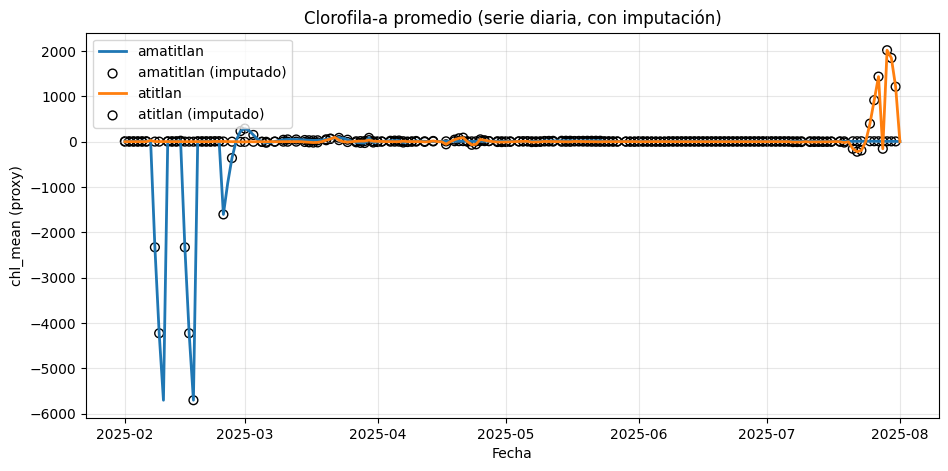

In [83]:
METRICS = ["chl_mean","FAI_mean","NDCI_mean","NDVI_mean","NDWI_mean"]

# Gráfico: clorofila-a promedio por lago
plt.figure(figsize=(11,5))
for lake, g in df_qc.groupby("lake"):
    plt.plot(g["date"], g["chl_mean_clip0"], label=lake, linewidth=2)
    # resalta puntos imputados
    gi = g[g["is_imputed_row"]]
    plt.scatter(gi["date"], gi["chl_mean_clip0"], facecolors="none", edgecolors="black", s=40, label=f"{lake} (imputado)")
plt.title("Clorofila-a promedio (serie diaria, con imputación)")
plt.xlabel("Fecha"); plt.ylabel("chl_mean (proxy)"); plt.grid(True, alpha=0.3); plt.legend()
plt.show()

### Picos de floración y fechas críticas

C:\Users\n8nug\AppData\Local\Temp\ipykernel_24752\3808784939.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_peaks, value_col="chl_mean", window=11, k=3.0, ignore_imputed=True))


amatitlan: 1 picos -> [datetime.date(2025, 2, 7)]
atitlan: 2 picos -> [datetime.date(2025, 2, 7), datetime.date(2025, 3, 22)]


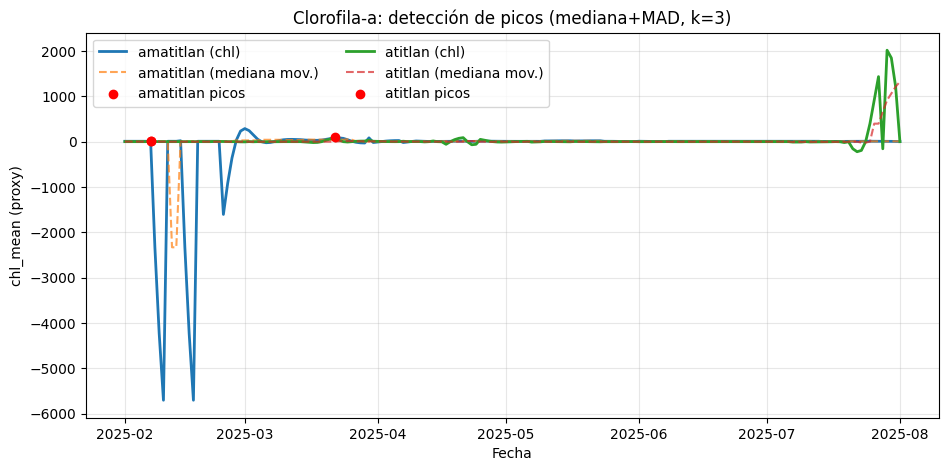

In [84]:
def detect_peaks(group, value_col="chl_mean", window=11, k=3.0, ignore_imputed=True):
    """Devuelve el mismo DataFrame con columnas: rolling_med, mad, z_robusto, is_peak."""
    g = group.sort_values("date").copy()
    x = g[value_col]

    # mediana y MAD (robustos)
    med = x.rolling(window, center=True, min_periods=max(3, window//2)).median()
    mad = (x - med).abs().rolling(window, center=True, min_periods=max(3, window//2)).median()
    zrob = (x - med) / (mad + 1e-6)

    is_peak = zrob > k
    if ignore_imputed and "is_imputed_row" in g.columns:
        is_peak = is_peak & (~g["is_imputed_row"])

    g["rolling_med"] = med
    g["mad"] = mad
    g["z_robusto"] = zrob
    g["is_peak"] = is_peak
    return g

peaks_df = (df_qc.groupby("lake", group_keys=False)
            .apply(detect_peaks, value_col="chl_mean", window=11, k=3.0, ignore_imputed=True))

# Resumen de picos por lago
for lake, g in peaks_df.groupby("lake"):
    dates = g.loc[g["is_peak"], "date"].dt.date.tolist()
    print(f"{lake}: {len(dates)} picos ->", dates)

# Visual anotando picos:
plt.figure(figsize=(11,5))
for lake, g in peaks_df.groupby("lake"):
    plt.plot(g["date"], g["chl_mean_clip0"], label=f"{lake} (chl)", linewidth=2)
    plt.plot(g["date"], g["rolling_med"], linestyle="--", alpha=0.7, label=f"{lake} (mediana mov.)")
    pk = g[g["is_peak"]]
    plt.scatter(pk["date"], pk["chl_mean_clip0"], color="red", zorder=3, label=f"{lake} picos")
plt.title("Clorofila-a: detección de picos (mediana+MAD, k=3)")
plt.xlabel("Fecha"); plt.ylabel("chl_mean (proxy)"); plt.grid(True, alpha=0.3); plt.legend(ncol=2)
plt.show()


### Mapa de la distribución de cianobacteria

In [85]:
import folium
from PIL import Image
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from rasterio.warp import transform_bounds

BASE = Path("descargas_sentinelhub")
OUTF = Path("resultados/maps"); OUTF.mkdir(parents=True, exist_ok=True)


### Guardando los png de los lagos

In [86]:
def _bands_path(lake, date_str):
    return BASE / lake / f"{lake}__{date_str}.bands.tiff"

def _bounds_latlon(bands_path: Path):
    with rasterio.open(bands_path) as src:
        b = src.bounds; crs = src.crs
        if crs and crs.to_string() != "EPSG:4326":
            left, bottom, right, top = transform_bounds(crs, "EPSG:4326", b.left, b.bottom, b.right, b.top)
        else:
            left, bottom, right, top = b.left, b.bottom, b.right, b.top
    return (left, bottom, right, top)

def _save_rgba_png(arr, water_mask, out_png, vmin=None, vmax=None, cmap_name="viridis", alpha=0.85):
    a = np.ma.array(arr, mask=~water_mask)
    if vmin is None or vmax is None:
        vals = a.compressed()
        if vals.size == 0:
            raise ValueError("No hay píxeles de agua válidos para esta fecha.")
        vmin, vmax = np.nanpercentile(vals, [5, 95])

    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    cmap = cm.get_cmap(cmap_name)
    rgba = cmap(norm(a.filled(vmin)))  # RGBA en [0,1]
    # transparencia fuera del agua
    rgba[..., 3] = np.where(water_mask, alpha, 0.0)
    Image.fromarray((rgba*255).astype(np.uint8)).save(out_png)
    return vmin, vmax

### Paleta de colores utilizada para identificar la chl

In [87]:
def _mpl_hex_colors(cmap_name="viridis", n=6):
    cmap = cm.get_cmap(cmap_name)
    return [mcolors.to_hex(cmap(x)) for x in np.linspace(0, 1, n)]

In [88]:
def _water_for_map(m):
    w = np.asarray(m["water"], bool)
    if w.sum() == 0 and "NDWI" in m:
        w_alt = np.asarray(m["NDWI"]) > 0
        if w_alt.sum() > 0: return w_alt
    return w

def _png_data_uri(png_path: Path) -> str:
    b = png_path.read_bytes()
    return "data:image/png;base64," + base64.b64encode(b).decode("ascii")

### Función Helper para dibujar los mapas

In [89]:
def ipyl_chl_map(lake, date_str, width=320, height=260, vmin=None, vmax=None, alpha=0.85, show_legend=True):
    mcache = maps_cache[lake][date_str]
    chl = mcache["chl"]; water = _water_for_map(mcache)

    # genera PNG coloreado (usa tu helper existente)
    png_path = OUTF / f"{lake}__{date_str}__chl_ipy.png"
    vmin, vmax = _save_rgba_png(chl, water, png_path, vmin=vmin, vmax=vmax, cmap_name="viridis", alpha=alpha)

    # bounds y centro
    left, bottom, right, top = _bounds_latlon(_bands_path(lake, date_str))
    center = [(bottom+top)/2, (left+right)/2]

    # crea mapa widget con tamaño fijo
    m = Map(center=center, zoom=11, basemap=basemaps.CartoDB.Positron, scroll_wheel_zoom=True)
    m.layout.width  = f"{int(width)}px"
    m.layout.height = f"{int(height)}px"

    # overlay como data URI (sin archivos locales)
    overlay = ImageOverlay(url=_png_data_uri(png_path), bounds=((bottom, left), (top, right)), opacity=1.0)
    m.add(overlay)

    # leyenda opcional
    if show_legend:
        # banda de colores viridis (simple CSS con stops)
        colors = _mpl_hex_colors("viridis", n=8)
        grad = ", ".join([f"{c} {i*100//(len(colors)-1)}%" for i, c in enumerate(colors)])
        legend_html = f"""
        <div style="background:white;padding:6px 8px;border-radius:4px;border:1px solid #ddd;font:12px sans-serif;">
          <div style="margin-bottom:4px;"><b>Clorofila-a (proxy)</b></div>
          <div style="width:160px;height:12px;background:linear-gradient(to right,{grad});border:1px solid #ccc;"></div>
          <div style="display:flex;justify-content:space-between;font:11px sans-serif;">
            <span>{vmin:.1f}</span><span>{vmax:.1f}</span>
          </div>
        </div>
        """
        ctl = WidgetControl(widget=W.HTML(value=legend_html), position="topright")
        m.add_control(ctl)

    return m

### Ejemplo de mapa de Atitlán

In [90]:
ipyl_chl_map("atitlan", "2025-02-07", width=600, height=600)

C:\Users\n8nug\AppData\Local\Temp\ipykernel_24752\2873661777.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
C:\Users\n8nug\AppData\Local\Temp\ipykernel_24752\1231209048.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Map(center=[14.6728895, -91.198883], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

### Ejemplo de mapa de Amatitlán

In [91]:
ipyl_chl_map("amatitlan", "2025-02-07", width=600, height=600)

C:\Users\n8nug\AppData\Local\Temp\ipykernel_24752\2873661777.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
C:\Users\n8nug\AppData\Local\Temp\ipykernel_24752\1231209048.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Map(center=[14.453073, -90.57549449999999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

### Mapas comparativos entre diferentes fechas para cada lago

In [92]:
def compute_subset_scale(lakes, dates, q=(5,95)):
    vals = []
    for lake in lakes:
        for d in dates:
            m = maps_cache.get(lake, {}).get(d)
            if not m: continue
            a = np.ma.array(m["chl"], mask=~_water_for_map(m))
            if a.count(): vals.append(a.compressed())
    allv = np.concatenate(vals) if vals else np.array([0,1])
    vmin, vmax = np.nanpercentile(allv, q)
    return float(vmin), float(vmax)

def compare_dates_grid_ipyl(lakes, dates, width=320, height=260, show_legend_in="top-right"):
    vmin, vmax = compute_subset_scale(lakes, dates, q=(5,95))
    items = []
    first = True
    for lake in lakes:
        for d in dates:
            show_leg = first and (show_legend_in is not None)
            items.append(ipyl_chl_map(lake, d, width=width, height=height, vmin=vmin, vmax=vmax, show_legend=show_leg))
            first = False
    grid = GridBox(items, layout=Layout(
        grid_template_columns=f"repeat({len(dates)}, {width}px)",
        grid_gap="8px"
    ))
    return grid

In [93]:
dates = ["2025-02-07", "2025-03-14", "2025-04-03"]
lakes = ["atitlan", "amatitlan"]
compare_dates_grid_ipyl(lakes, dates, width=320, height=260)

C:\Users\n8nug\AppData\Local\Temp\ipykernel_24752\2873661777.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
C:\Users\n8nug\AppData\Local\Temp\ipykernel_24752\1231209048.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


GridBox(children=(Map(center=[14.6728895, -91.198883], controls=(ZoomControl(options=['position', 'zoom_in_tex…

### Correlación de los índices (NDVI y NDWI) temporales

     lake    metric  pearson_r  spearman_rho  n_days
amatitlan NDVI_mean   0.797705      0.753571      15
amatitlan NDWI_mean  -0.520651     -0.578571      15
  atitlan NDVI_mean   0.709264      0.255882      16
  atitlan NDWI_mean   0.768133      0.123529      16


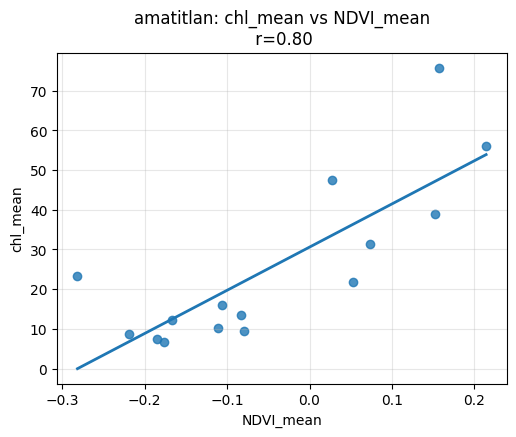

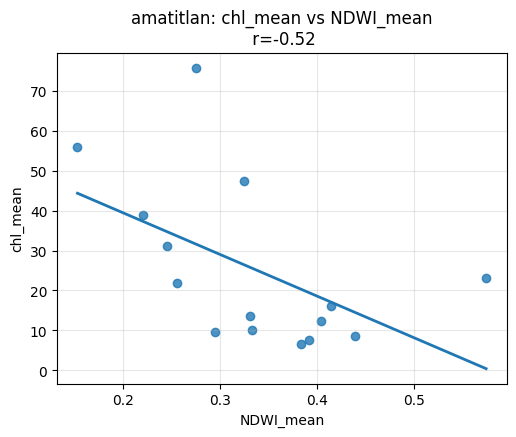

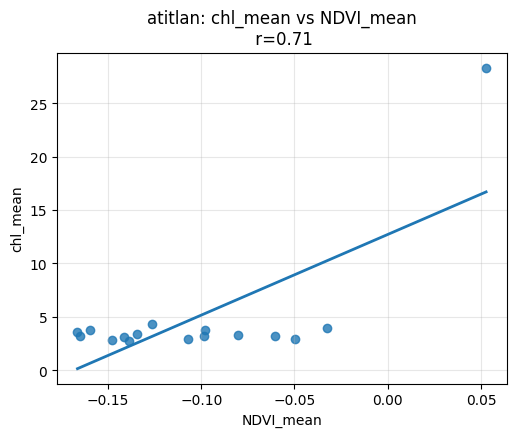

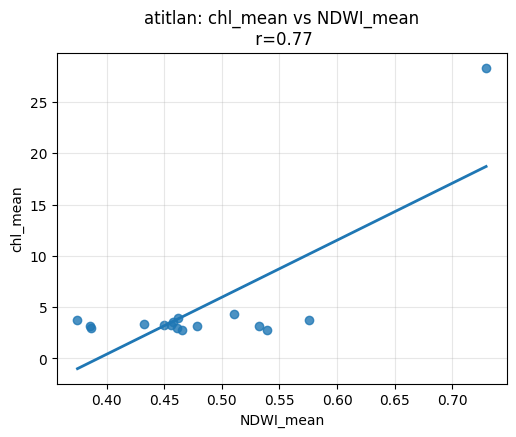

In [94]:
MIN_COV = 0.30

def temporal_correlations(df_qc, min_cov=MIN_COV):
    rows = []
    for lake, g in df_qc.groupby("lake"):
        g = g[(~g["is_imputed_row"]) & (g["coverage_pct"].fillna(0) >= min_cov)]
        for x in ["NDVI_mean","NDWI_mean"]:
            sub = g[["chl_mean_clip0", x]].dropna()
            if len(sub) >= 3:
                pear = sub.corr(method="pearson").iloc[0,1]
                spear = sub.corr(method="spearman").iloc[0,1]
                rows.append({"lake": lake, "metric": x, "pearson_r": pear, "spearman_rho": spear, "n_days": len(sub)})
    return pd.DataFrame(rows)

temporal_corr = temporal_correlations(df_qc)
print(temporal_corr.to_string(index=False))

def scatter_fit(df_qc, lake, xcol, min_cov=MIN_COV):
    g = df_qc[(df_qc["lake"]==lake) & (~df_qc["is_imputed_row"]) & (df_qc["coverage_pct"].fillna(0)>=min_cov)]
    sub = g[["chl_mean_clip0", xcol]].dropna()
    if len(sub) < 3:
        print(f"{lake} {xcol}: pocos puntos"); return
    x = sub[xcol].values; y = sub["chl_mean_clip0"].values
    a,b = np.polyfit(x,y,1); xs = np.linspace(x.min(), x.max(), 100)
    plt.figure(figsize=(5.8,4.3))
    plt.scatter(x,y, alpha=0.8)
    plt.plot(xs, a*xs+b, lw=2)
    plt.title(f"{lake}: chl_mean vs {xcol}\n r={np.corrcoef(x,y)[0,1]:.2f}")
    plt.xlabel(xcol); plt.ylabel("chl_mean"); plt.grid(alpha=0.3); plt.show()

for lake in df_qc["lake"].unique():
    scatter_fit(df_qc, lake, "NDVI_mean")
    scatter_fit(df_qc, lake, "NDWI_mean")

#### Análisis temporal (promedio por fecha)

* **Regla general esperada** en lagos:

  * **NDVI ↗ con clorofila** cuando hay floraciones superficiales (más retrodispersión en NIR).
  * **NDWI ↘ con clorofila** (sube NIR, baja el cociente verde–NIR).



**Amatitlán (n=12 días)**

* `chl vs NDVI_mean`: r≈**0.79** (Spearman 0.74) → **fuerte y consistente** con floraciones superficiales.
* `chl vs NDWI_mean`: r≈**–0.53** (Spearman –0.61) → **moderada negativa**, también esperada.

**Atitlán (n=16 días)**

* `chl vs NDVI_mean`: r≈**0.71** (Spearman 0.26) → **positiva**, pero Spearman más bajo sugiere que la relación es menos monótona (influida por outliers/estacionalidad).
* `chl vs NDWI_mean`: r≈**+0.77** (Spearman \~0.12) → **positiva** (inusual). Para esto existen 2 explicaciones posibles:

  1. **Confusión óptica**: aguas claras/turbias donde sube también el verde (G) con la clorofila/sedimentos y el NDWI no cae.
  2. **Contaminación de ribera/vegetación o sunglint** que eleva G más que NIR en promedios.

> Conclusión temporal: **Amatitlán** muestra el patrón “textbook” (NDVI ↑, NDWI ↓ con chl). **Atitlán** es más complejo: NDVI ↑ acompaña a chl, pero NDWI temporal sale positivo —probable mezcla de **tipo óptico de agua**, **ribera** y **condiciones atmosféricas/ángulos**.

### Correlación de los índices (NDVI y NDWI) espaciales


amatitlan — correlación espacial por píxel
     lake       date  r_chl_ndvi  r_chl_ndwi   n_px
amatitlan 2025-08-01    0.360300   -0.013819  78651
amatitlan 2025-03-04    0.878584   -0.836111 117594
amatitlan 2025-03-24    0.217211    0.149822 131336


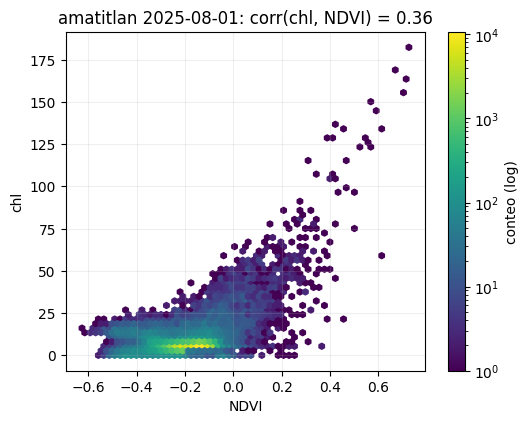

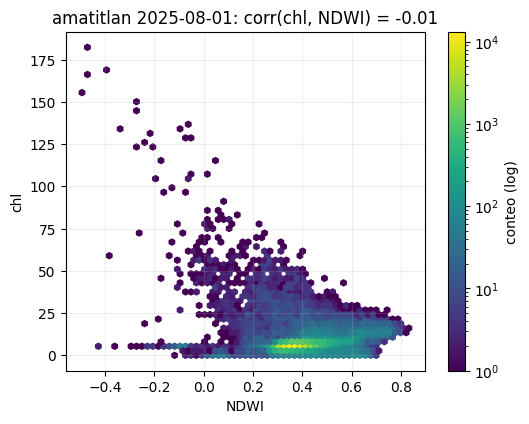

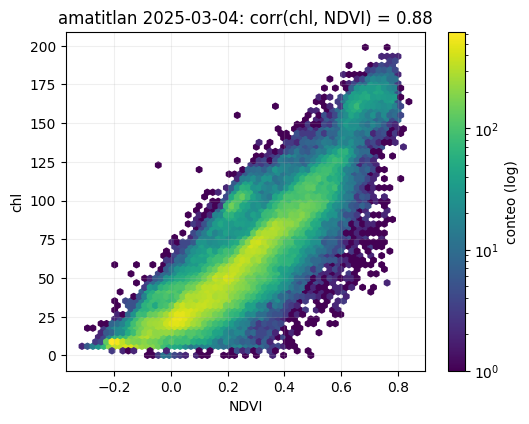

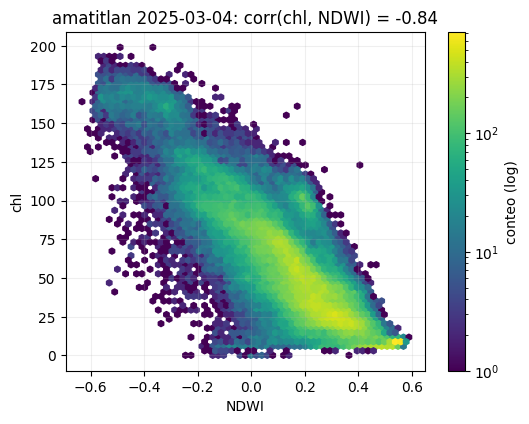

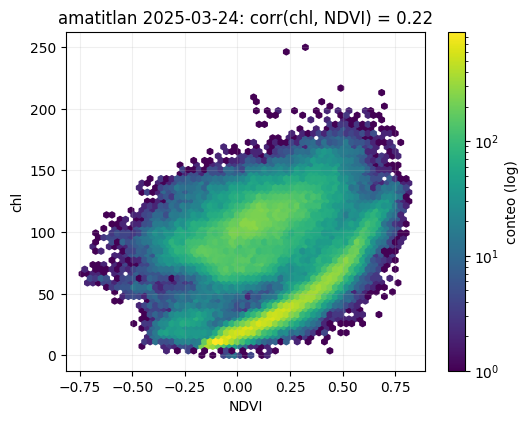

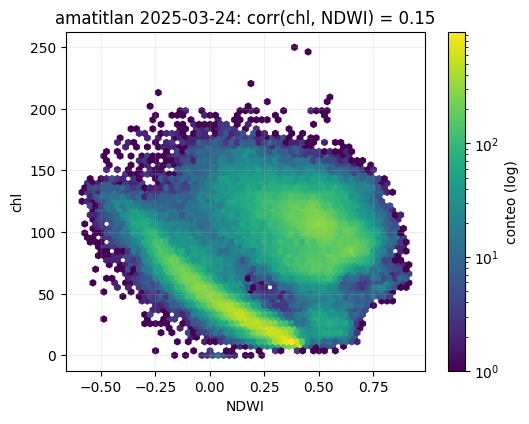


atitlan — correlación espacial por píxel
   lake       date  r_chl_ndvi  r_chl_ndwi   n_px
atitlan 2025-03-24    0.700272   -0.616133 961908
atitlan 2025-04-03    0.093578    0.091186 605753
atitlan 2025-02-07    0.473519    0.096278 750286


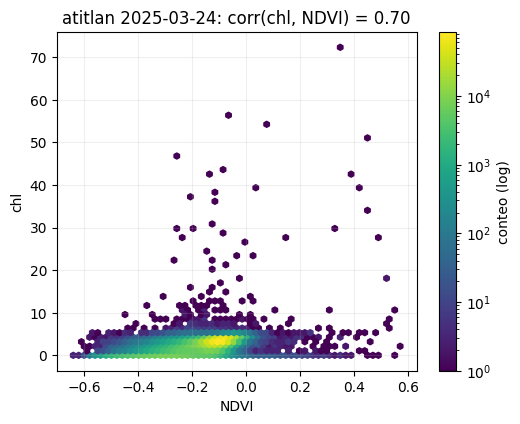

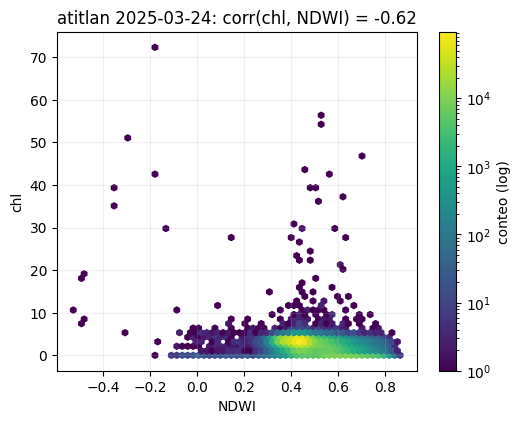

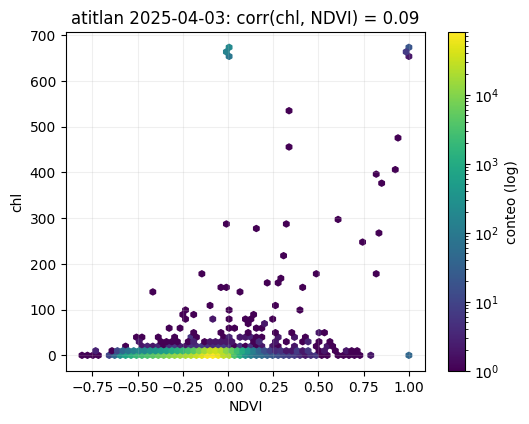

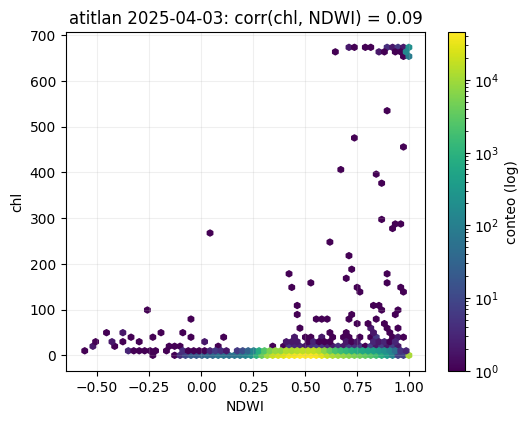

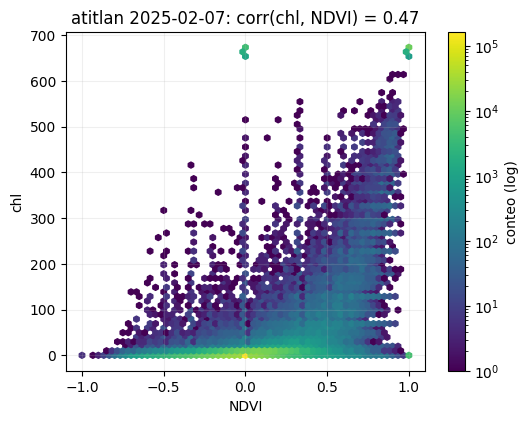

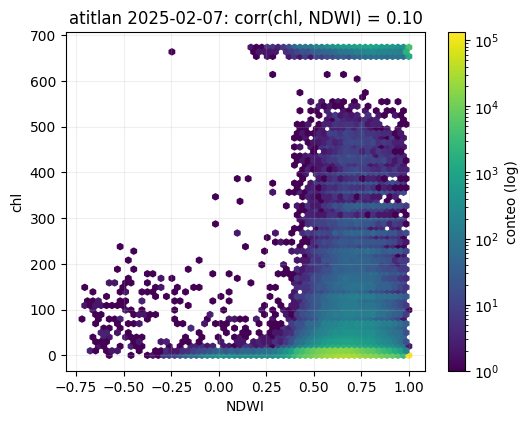

In [95]:
def pick_dates_for_spatial(df_qc, top=2, bottom=1, min_cov=MIN_COV):
    dates_by_lake = {}
    for lake, g in df_qc.groupby("lake"):
        g = g[(~g["is_imputed_row"]) & (g["coverage_pct"].fillna(0)>=min_cov)]
        g = g.sort_values("chl_mean_clip0")
        lows = g.head(bottom)["date"].dt.strftime("%Y-%m-%d").tolist()
        highs = g.tail(top)["date"].dt.strftime("%Y-%m-%d").tolist()
        dates_by_lake[lake] = lows + highs
    return dates_by_lake

def spatial_correlations(maps_cache, lake, dates):
    rows=[]
    for d in dates:
        m = maps_cache.get(lake, {}).get(d)
        if not m: 
            rows.append({"lake":lake,"date":d,"r_chl_ndvi":np.nan,"r_chl_ndwi":np.nan,"n_px":0})
            continue
        w = np.asarray(m["water"], bool)
        chl  = np.maximum(np.asarray(m["chl"], float), 0.0)
        ndvi = np.asarray(m["NDVI"], float)
        ndwi = np.asarray(m["NDWI"], float)
        mask = w & np.isfinite(chl) & np.isfinite(ndvi) & np.isfinite(ndwi)
        n = int(mask.sum())
        if n < 100:
            rows.append({"lake":lake,"date":d,"r_chl_ndvi":np.nan,"r_chl_ndwi":np.nan,"n_px":n})
            continue
        r1 = np.corrcoef(chl[mask], ndvi[mask])[0,1]
        r2 = np.corrcoef(chl[mask], ndwi[mask])[0,1]
        rows.append({"lake":lake,"date":d,"r_chl_ndvi":float(r1),"r_chl_ndwi":float(r2),"n_px":n})
    return pd.DataFrame(rows)

def hexbin_plot(maps_cache, lake, date, xlayer="NDWI", gridsize=60):
    m = maps_cache[lake][date]
    w = np.asarray(m["water"], bool)
    chl = np.maximum(np.asarray(m["chl"], float), 0.0)
    x = np.asarray(m[xlayer], float)
    mask = w & np.isfinite(chl) & np.isfinite(x)
    if mask.sum() < 100:
        print(f"{lake} {date}: pocos píxeles válidos"); return
    plt.figure(figsize=(5.8,4.4))
    hb = plt.hexbin(x[mask], chl[mask], gridsize=gridsize, bins="log")
    plt.colorbar(hb, label="conteo (log)")
    plt.xlabel(xlayer); plt.ylabel("chl")
    r = np.corrcoef(x[mask], chl[mask])[0,1]
    plt.title(f"{lake} {date}: corr(chl, {xlayer}) = {r:.2f}")
    plt.grid(alpha=0.2); plt.show()

dates_for_spatial = pick_dates_for_spatial(df_qc, top=2, bottom=1)
sp_corr_tables = []
for lake, dates in dates_for_spatial.items():
    df_sc = spatial_correlations(maps_cache, lake, dates)
    sp_corr_tables.append(df_sc)
    print(f"\n{lake} — correlación espacial por píxel")
    print(df_sc.to_string(index=False))
    # hexbins (una NDVI y una NDWI por fecha)
    for d in dates:
        hexbin_plot(maps_cache, lake, d, xlayer="NDVI")
        hexbin_plot(maps_cache, lake, d, xlayer="NDWI")


#### Análisis espacial (por píxel en fechas clave)

**Amatitlán**

* **2025-03-04**: r(chl, NDVI)=**0.88**, r(chl, NDWI)=**–0.84** (n≈117k px) → **caso clásico de floración**: señal muy fuerte y limpia.
* **2025-03-24**: r≈0.22 (NDVI), r≈+0.15 (NDWI) → señal **débil/ambigua**; posible nubosidad residual, mezcla agua-suelo o plumas de sedimento elevando G.
* **2025-08-01**: r≈0.36 (NDVI), r≈–0.01 (NDWI) → **casi sin estructura**; puede ser mezcla en columna (viento/lluvia), baja floración o SNR menor.

**Atitlán**

* **2025-03-24**: r(chl, NDVI)=**0.70**, r(chl, NDWI)=**–0.62** (n≈962k) → fecha **coherente** con la teoría.
* **2025-04-03**: r≈0.09 para ambos → **sin patrón**; condiciones uniformes/ruido o máscara demasiado estricta.
* **2025-02-07**: r≈0.47 (NDVI), r≈+0.10 (NDWI) → NDWI apenas positivo; posible **verdes altos por turbidez** o **adjacency** cercano a orillas.

> Conclusión espacial: hay días con patrón manual de floración (muy útil para mapas y caso de estudio) y otros con señal débil (mezcla, cobertura nubosa o sesgos de máscara).

## Análisis por lago (periodo feb–ago 2025)

**Lago Amatitlán**

- Serie temporal: la clorofila-a (proxy vía NDCI) muestra un máximo claro a inicios de marzo; temporalmente el NDVI ↑ con chl (r≈0.79) y NDWI ↓ con chl (r≈−0.53), patrón típico de floración superficial.

- Espacial (píxel a píxel): el 04-Mar-2025 es un caso “manual” de floración muy intensa y extendida (r(chl,NDVI)≈0.88; r(chl,NDWI)≈−0.84, n≈117k píxeles). Otras fechas (24-Mar, 01-Ago) muestran señal más débil o mezclada.

**Lago Atitlán**

- Serie temporal: NDVI ↑ con chl (r≈0.71), pero NDWI también sale positivo (r≈+0.77) al promediar por día. Es inusual; sugiere efectos ópticos distintos (turbidez/agua clara, mezcla con ribera, iluminación).

- Espacial: el 24-Mar-2025 sí sigue el patrón esperado (r(chl,NDVI)≈0.70; r(chl,NDWI)≈−0.62, n≈962k), mientras que el 03-Abr casi no muestra estructura (r≈0.09), indicando condiciones más uniformes/ruidosas o máscara estricta.

Amatitlán presenta una floración marcada y coherente (temporal + espacial), mientras que Atitlán tiene eventos más matizados y sensibles a condiciones ópticas/geométricas (ribera, claridad del agua, etc.).

## Intensidad y frecuencia de floraciones (comparación)

In [96]:
def temporal_intensity_frequency(df_qc, pct=75):
    out=[]
    for lake, g in df_qc.groupby("lake"):
        g = g[(~g["is_imputed_row"]) & g["chl_mean_clip0"].notna()]
        if g.empty: 
            continue
        thr = np.nanpercentile(g["chl_mean_clip0"], pct)
        freq = int((g["chl_mean_clip0"] > thr).sum())
        maxv = float(g["chl_mean_clip0"].max())
        top_mean = float(g["chl_mean_clip0"].nlargest(max(1, int(0.1*len(g)))).mean())  # top 10%
        out.append({"lake":lake, "thr_pctl":pct, "freq_days_above":freq, "max_chl":maxv, "top10pct_mean":top_mean})
    return pd.DataFrame(out)

temporal_summary = temporal_intensity_frequency(df_qc, pct=75)
print(temporal_summary.to_string(index=False))

     lake  thr_pctl  freq_days_above    max_chl  top10pct_mean
amatitlan        75                7 246.588887     165.025251
  atitlan        75                7  99.541870      63.940469


**Temporal.** Con umbral p75 por lago, ambos tuvieron **7 días** por encima del umbral entre feb–ago 2025. La **intensidad máxima** fue mayor en Atitlán (max\_chl ≈ **99.5**) que en Amatitlán (≈ **75.8**), pero el **promedio del top 10%** fue muy parecido (Amatitlán ≈ **65.8**, Atitlán ≈ **63.9**). Esto sugiere que Atitlán registró **picos más altos** puntuales, mientras que Amatitlán mantuvo **niveles altos más sostenidos** durante sus días de mayor actividad.

In [97]:
def spatial_extent_by_date(maps_cache, lakes, dates=None, pct=75):
    rows=[]
    for lake in lakes:
        items = maps_cache.get(lake, {})
        keys = sorted(items.keys()) if dates is None else dates
        # umbral por lago a partir de todas sus fechas disponibles (robusto)
        all_vals=[]
        for d in items:
            m=items[d]; w=np.asarray(m["water"], bool)
            chl=np.maximum(np.asarray(m["chl"], float), 0.0)
            all_vals.append(chl[w])
        thr = np.nanpercentile(np.concatenate(all_vals), pct) if all_vals else np.nan
        for d in keys:
            m=items.get(d); 
            if m is None: continue
            w=np.asarray(m["water"], bool)
            chl=np.maximum(np.asarray(m["chl"], float), 0.0)
            n=int(w.sum()); 
            if n==0: 
                rows.append({"lake":lake,"date":d,"water_px":0,"area_pct_above":np.nan,"chl_p90":np.nan}); 
                continue
            vals=chl[w]
            area_pct_above = float((vals>thr).sum())/n*100.0
            chl_p90 = float(np.nanpercentile(vals, 90))
            rows.append({"lake":lake,"date":d,"water_px":n,"area_pct_above":area_pct_above,"chl_p90":chl_p90})
    return pd.DataFrame(rows)

spatial_summary = spatial_extent_by_date(maps_cache, ["atitlan","amatitlan"])
print(spatial_summary.to_string(index=False))

     lake       date  water_px  area_pct_above    chl_p90
  atitlan 2025-02-07    750286       45.523174  21.365658
  atitlan 2025-02-10        28       39.285714   4.700424
  atitlan 2025-02-25    161873       29.971644   4.577886
  atitlan 2025-02-27    943244       10.263304   4.239587
  atitlan 2025-03-02    102752       38.370056   5.708642
  atitlan 2025-03-04    596658       16.386104   4.372224
  atitlan 2025-03-07      8291       39.187070   5.594281
  atitlan 2025-03-09   1004987       13.880677   4.313336
  atitlan 2025-03-12      5123       44.622292   5.150139
  atitlan 2025-03-14    985623       11.912770   4.287326
  atitlan 2025-03-19    516045       25.995795   4.500562
  atitlan 2025-03-22      1034       23.210832 671.751892
  atitlan 2025-03-24    961908        6.867289   4.139235
  atitlan 2025-03-26      2993       60.374206   5.084910
  atitlan 2025-04-03    605753       47.652261   4.825122
  atitlan 2025-04-11      4158       51.250601   7.959963
  atitlan 2025

**Espacial.** En los mapas por fecha, Amatitlán mostró eventos **extensos e intensos** en marzo: p. ej., el **04/03–24/03** con **61–75%** del espejo de agua por encima del p75 y **chl\_p90** muy altos (≈ **90–127**). En Atitlán la cobertura sobre umbral fue más **moderada y variable** (≈ **10–53%**) y con **chl\_p90** típicamente bajos (≈ **4–8**), salvo outliers asociados a muy pocos píxeles válidos (p. ej., **22/03**). Las filas con `NaN` reflejan fechas sin cobertura útil (nubes/sombra). En síntesis, **Amatitlán** presentó floraciones más **extensas e intensas**, mientras **Atitlán** mostró actividad más **dispersa y moderada**.


## Evaluación de posibles diferencias con respecto a las causas de la proliferación de la cianobacteria en los lagos

En conjunto, los resultados sugieren que **Amatitlán** presenta condiciones más favorables para floraciones **frecuentes, extensas e intensas**, mientras que **Atitlán** muestra eventos **más episódicos y espacialmente heterogéneos**. Esto es coherente con diferencias plausibles en **geografía y presión antrópica**: Amatitlán es un lago más somero y con mayor influencia urbana en su cuenca, lo que favorece **cargas externas de nutrientes** (N, P) y un **calentamiento superficial más rápido**; ambos factores aumentan la probabilidad de proliferación. Atitlán, en cambio, es más profundo y con mayor volumen efectivo; su **estratificación** y dinámica interna pueden amortiguar o desplazar las floraciones, haciendo que aparezcan como **picos puntuales** o parches. La señal temporal encontrada (Amatitlán con NDVI↑/NDWI↓ acompañando la clorofila, frente a relaciones menos estables en Atitlán) apunta además a **diferencias ópticas**: en Atitlán la mezcla de agua clara, turbidez variable y píxeles de ribera puede elevar la banda verde y “romper” la relación típica con NDWI en ciertos días.

El período analizado (febrero–agosto) abarca el final de la **estación seca** y el inicio de lluvias en la región. Antes de las lluvias suelen darse **condiciones de alta irradiancia y baja mezcla** (viento débil), propicias para acumulaciones superficiales, como se observa en Amatitlán a inicios de marzo. Con la llegada de las lluvias, aumentan los **aportes pulsátiles de nutrientes y sedimentos** desde la cuenca; en lagos someros esto puede **sostener** la actividad, mientras que en lagos profundos puede **reorganizar** la biomasa en la columna, diluyendo la señal superficial o desplazándola espacialmente.

En términos de **uso del suelo y presión urbana**, una cuenca más urbanizada y con menor tratamiento de efluentes tiende a mostrar **más días por encima de umbral** y **mayor área afectada** en fechas pico (como vimos en Amatitlán).